In [1]:
pip install torch torchvision faiss-cpu pillow


  Using cached faiss_cpu-1.10.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (4.4 kB)
Using cached faiss_cpu-1.10.0-cp311-cp311-manylinux_2_28_x86_64.whl (30.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import zipfile
import os

zip_path = "augmented_images(Stef).zip"         # Replace with your zip file path
extract_to = "augmented_images(Stef)"    # Replace with your desired output folder

# Create target folder if not exists
os.makedirs(extract_to, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to: {extract_to}")

Extracted to: augmented_images(Stef)


In [3]:
import os
import re
import torch
import faiss
import pickle
import numpy as np
from PIL import Image
from torchvision import models, transforms
from collections import defaultdict

In [6]:
# --- CONFIGURE YOUR PATH HERE ---
main_folder = r"augmented_images(Stef)"  

# Load model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove final layer
model.eval().to(device)


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [7]:
# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Clean medication name
def extract_medication_name(filename):
    name = os.path.splitext(filename)[0]
    name = re.sub(r'_aug_\d+', '', name)
    name = re.sub(r'_\d+$', '', name)
    name = re.sub(r'\[[^\]]*\]', '', name)
    name = re.sub(r'[-–](Box|Front box|Blister|Back|Front)', '', name, flags=re.IGNORECASE)
    name = re.sub(r'\(MA.*?\)', '', name)
    name = re.sub(r'\(M&mf.*?\)', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [8]:
# Extract image embeddings
def extract_embedding(img_path):
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model(img_tensor).squeeze().cpu().numpy()
    return emb

# Initialize data stores
embedding_dim = 2048
image_paths = []
med_names = []
embeddings = []
med_to_images = defaultdict(list)
count = 0
total = sum([len(files) for r, d, files in os.walk(main_folder) if any(f.lower().endswith((".jpg", ".jpeg", ".png")) for f in files)])

for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for root, _, files in os.walk(subfolder_path):
            for file in files:
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    full_path = os.path.join(root, file)
                    med_name = extract_medication_name(file)
                    
                    try:
                        emb = extract_embedding(full_path)
                    except Exception as e:
                        print(f"❌ Error processing {file}: {e}")
                        continue
                    
                    med_to_images[med_name].append(full_path)
                    image_paths.append(full_path)
                    med_names.append(med_name)
                    embeddings.append(emb)

                    count += 1
                    if count % 500 == 0:
                        print(f"✅ Processed {count}/{total} images...")


✅ Processed 500/30130 images...
✅ Processed 1000/30130 images...
✅ Processed 1500/30130 images...
✅ Processed 2000/30130 images...
✅ Processed 2500/30130 images...
✅ Processed 3000/30130 images...
✅ Processed 3500/30130 images...
✅ Processed 4000/30130 images...
✅ Processed 4500/30130 images...
✅ Processed 5000/30130 images...
✅ Processed 5500/30130 images...
✅ Processed 6000/30130 images...
✅ Processed 6500/30130 images...
✅ Processed 7000/30130 images...
✅ Processed 7500/30130 images...
✅ Processed 8000/30130 images...
✅ Processed 8500/30130 images...
✅ Processed 9000/30130 images...
✅ Processed 9500/30130 images...
✅ Processed 10000/30130 images...
✅ Processed 10500/30130 images...
✅ Processed 11000/30130 images...
✅ Processed 11500/30130 images...
✅ Processed 12000/30130 images...
✅ Processed 12500/30130 images...
✅ Processed 13000/30130 images...
✅ Processed 13500/30130 images...
✅ Processed 14000/30130 images...
✅ Processed 14500/30130 images...
✅ Processed 15000/30130 images...


In [9]:
# Build FAISS index
embeddings_np = np.vstack(embeddings)
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings_np)

In [10]:
# Save outputs
faiss.write_index(index, "med_faiss_index.index")
with open("med_image_paths.pkl", "wb") as f:
    pickle.dump(image_paths, f)
with open("med_names.pkl", "wb") as f:
    pickle.dump(med_names, f)

print(f"Done! Processed {len(image_paths)} images across {len(set(med_names))} unique medications.")

Done! Processed 30130 images across 3300 unique medications.


In [15]:
def extract_medication_key(med_name):
    # Only keep the medication + dosage, remove packaging or manufacturer
    med_key = re.split(r'\(|-', med_name)[0]  # Split at first '(' or '-' if present
    return med_key.strip()


In [52]:
query_img_path = r"augmented_images(Stef)/augmented_images(Stef)/augmented_images(boxes_blisters)/Activelle Tab_0_aug_1.jpg"
query_name = extract_medication_name(os.path.basename(query_img_path))
query_emb = extract_embedding(query_img_path).reshape(1, -1)

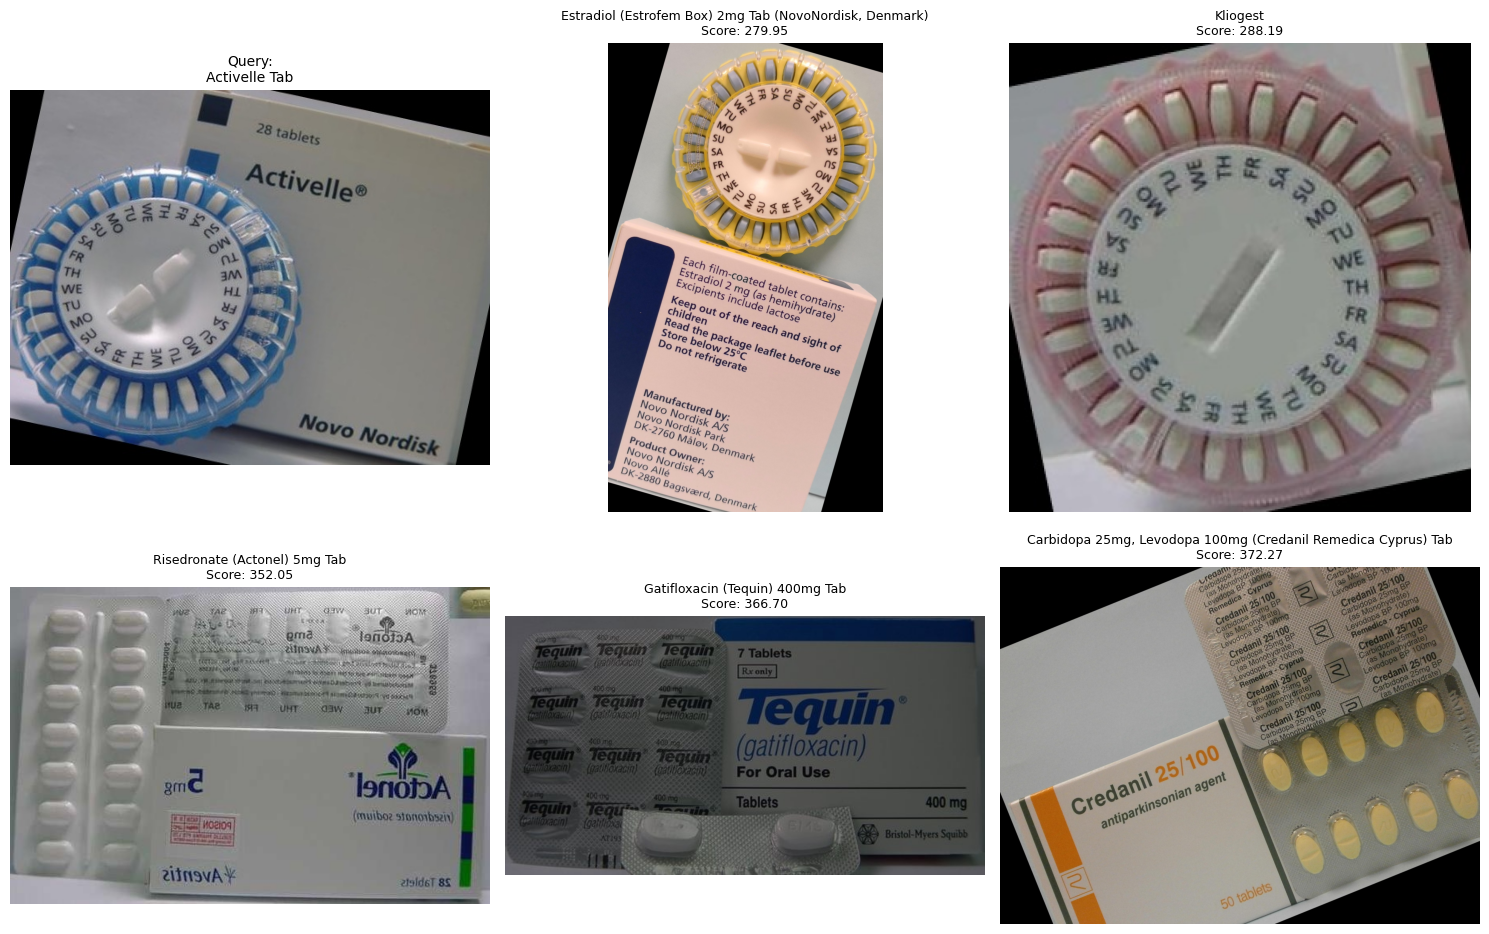

In [53]:
import matplotlib.pyplot as plt
from PIL import Image

# Helper to show an image
def show_image(title, path):
    img = Image.open(path).convert("RGB")
    plt.imshow(img)
    plt.title(title, fontsize=10)
    plt.axis("off")

# Run FAISS similarity search
D, I = index.search(query_emb, k=50)

# Track the best (closest) image for each unique medication key
medkey_to_best = {}

for dist, idx in zip(D[0], I[0]):
    candidate_name = med_names[idx]
    candidate_key = extract_medication_key(candidate_name)
    query_key = extract_medication_key(query_name)

    if candidate_key == query_key:
        continue  # Skip same med as query

    # Keep only the most similar image per medication
    if candidate_key not in medkey_to_best or dist < medkey_to_best[candidate_key][2]:
        medkey_to_best[candidate_key] = (candidate_name, image_paths[idx], dist)

# Now extract top 5 most similar meds
results = sorted(medkey_to_best.values(), key=lambda x: x[2])[:5]


# --- Display Grid (Query + 5 Similar) ---
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

# Show query image in position 0
query_img = Image.open(query_img_path).convert("RGB")
axs[0].imshow(query_img)
axs[0].set_title(f"Query:\n{query_name}", fontsize=10)
axs[0].axis("off")

# Show top 5 similar
for i, (name, path, dist) in enumerate(results):
    img = Image.open(path).convert("RGB")
    axs[i+1].imshow(img)
    axs[i+1].set_title(f"{name}\nScore: {dist:.2f}", fontsize=9)
    axs[i+1].axis("off")

# Hide any remaining axes
for j in range(len(results)+1, 6):
    axs[j].axis("off")

plt.tight_layout()
plt.show()




In [13]:
pip install matplotlib

  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (326 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.57.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Using cached kiwisolver-1.4.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl